# Libraries

In [1]:
# imports
import pandas as pd
import numpy as np
import json
import time
import matplotlib.pyplot as plt
from collections import Counter

import keras
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

# Import models from another notebook
%run model.ipynb
%run util.ipynb

Using TensorFlow backend.


# Preprocessing

In [2]:
# load inputs
sudokus = pd.read_csv('./datasets/sudoku-kaggle.csv').values
print("Full shape:", sudokus.shape)

Full shape: (1000000, 2)


In [3]:
# Examine first 5 rows
sudokus[:5]

array([['004300209005009001070060043006002087190007400050083000600000105003508690042910300',
        '864371259325849761971265843436192587198657432257483916689734125713528694542916378'],
       ['040100050107003960520008000000000017000906800803050620090060543600080700250097100',
        '346179258187523964529648371965832417472916835813754629798261543631485792254397186'],
       ['600120384008459072000006005000264030070080006940003000310000050089700000502000190',
        '695127384138459672724836915851264739273981546946573821317692458489715263562348197'],
       ['497200000100400005000016098620300040300900000001072600002005870000600004530097061',
        '497258316186439725253716498629381547375964182841572639962145873718623954534897261'],
       ['005910308009403060027500100030000201000820007006007004000080000640150700890000420',
        '465912378189473562327568149738645291954821637216397854573284916642159783891736425']],
      dtype=object)

In [4]:
# Preprocess
X_kaggle, y_kaggle = sudokus[:, 0], sudokus[:, 1]
X_kaggle, y_kaggle = preprocess(X_kaggle, y_kaggle, 
                                from_string=True, 
                                reshape=True, 
                                one_hot=False)

Initial shape of X: (1000000,)
Initial shape of y: (1000000,)
Convert strings in X to: (1000000, 81)
Convert strings in y to: (1000000, 81)
Reshape X to: (1000000, 9, 9)
Reshape y to: (1000000, 9, 9)


In [6]:
# After reshape
X_kaggle[0]

array([[0, 0, 4, 3, 0, 0, 2, 0, 9],
       [0, 0, 5, 0, 0, 9, 0, 0, 1],
       [0, 7, 0, 0, 6, 0, 0, 4, 3],
       [0, 0, 6, 0, 0, 2, 0, 8, 7],
       [1, 9, 0, 0, 0, 7, 4, 0, 0],
       [0, 5, 0, 0, 8, 3, 0, 0, 0],
       [6, 0, 0, 0, 0, 0, 1, 0, 5],
       [0, 0, 3, 5, 0, 8, 6, 9, 0],
       [0, 4, 2, 9, 1, 0, 3, 0, 0]])

Maximum #clues: 37
Minimum #clues: 29
Average #clues: 33.81279


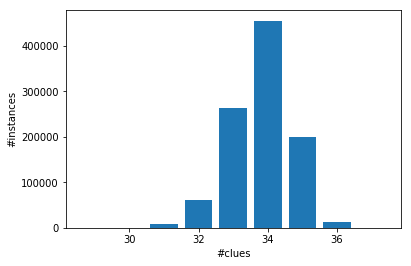

In [5]:
# Count clues
clues = np.sum(X_kaggle != 0, axis=(1, 2))
print("Maximum #clues:", np.max(clues))
print("Minimum #clues:", np.min(clues))
print("Average #clues:", np.mean(clues))

# plot bar
counter = Counter(clues)
plt.bar(counter.keys(), counter.values())
plt.xlabel('#clues')
plt.ylabel('#instances')
plt.show()

In [7]:
#   DEGREE OF DIFFICULTY   |  SCORE                                                
# -------------------------+------------------------------------------             
#   TRIVIAL                |  80 points or less                                    
#   EASY                   |  81 - 150 points                                      
#   MEDIUM                 |  151 - 250 points                                     
#   HARD                   |  251 - 400 points                                     
#   VERY HARD              |  401 - 900 points                                     
#   DIABOLICAL             |  901 and up                                           

evals = calculate_difficulty(X_kaggle[:10]) # TODO change

In [9]:
# Number of solutions # TODO rerun
counts = list(map(lambda x: int(x['counts'][0]), evals))
print("Maximum #solutions:", np.max(counts))
print("Minimum #solutions:", np.min(counts))
print("Average #solutions:", np.mean(counts))

Maximum #solutions: 1
Minimum #solutions: 1
Average #solutions: 1.0


In [10]:
# scores
scores = list(map(lambda x: int(x['scores'][0]), evals))
print("Maximum score:", np.max(scores))
print("Minimum score:", np.min(scores))
print("Average score:", np.mean(scores))

Maximum score: 49
Minimum score: 46
Average score: 47.2


In [5]:
# One-hot encoding
X_kaggle, y_kaggle = preprocess(X_kaggle, y_kaggle, 
                                from_string=False, 
                                reshape=False, 
                                one_hot=True)

Initial shape of X: (1000000, 9, 9)
Initial shape of y: (1000000, 9, 9)
Shape of one-hot X: (1000000, 9, 9, 10)
Shape of one-hot y: (1000000, 9, 9, 9)


In [6]:
# Get 50000 for training and testing only
X_kaggle_used, X_kaggle_hold, y_kaggle_used, y_kaggle_hold = train_test_split(X_kaggle, y_kaggle, 
                                                                              test_size=0.95,
                                                                              random_state=42)
print("Used X shape:", X_kaggle_used.shape)
print("Used y shape:", y_kaggle_used.shape)
print("Hold X shape:", X_kaggle_hold.shape)
print("Hold X shape:", y_kaggle_hold.shape)

Used X shape: (50000, 9, 9, 10)
Used y shape: (50000, 9, 9, 9)
Hold X shape: (950000, 9, 9, 10)
Hold X shape: (950000, 9, 9, 9)


In [7]:
# train, test, validation split
X_kaggle_train, X_kaggle_test, y_kaggle_train, y_kaggle_test = train_test_split(X_kaggle_used,
                                                                                y_kaggle_used,
                                                                                test_size=0.2, 
                                                                                random_state=42)
X_kaggle_train, X_kaggle_val, y_kaggle_train, y_kaggle_val = train_test_split(X_kaggle_train, 
                                                                              y_kaggle_train, 
                                                                              test_size=0.2, 
                                                                              random_state=42)
print("Training data shape:", X_kaggle_train.shape)
print("Training labels shape:", y_kaggle_train.shape)
print("Validation data shape:", X_kaggle_val.shape)
print("Validation labels shape:", y_kaggle_val.shape)
print("Testing data shape:", X_kaggle_test.shape)
print("Testing labels shape:", y_kaggle_test.shape)

Training data shape: (32000, 9, 9, 10)
Training labels shape: (32000, 9, 9, 9)
Validation data shape: (8000, 9, 9, 10)
Validation labels shape: (8000, 9, 9, 9)
Testing data shape: (10000, 9, 9, 10)
Testing labels shape: (10000, 9, 9, 9)


In [ ]:
# Completed puzzles create from solutions
X_kaggle_train_completed = to_puzzles(y_kaggle_train)
print("Completed training data shape:", X_kaggle_train_completed.shape)

# Training

### Dense model

In [10]:
dense = get_model(input_shape=X_kaggle_train.shape[1:], model_id='dense_model')
dense.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 9, 9, 10)     0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 5184)         4864        input_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 9)            46665       sequential_1[1][0]               
__________________________________________________________________________________________________
dense_4 (Dense)      

In [11]:
# hidden architecture
dense.layers[1].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 9, 9, 64)          704       
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9, 64)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 9, 9, 64)          4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)              0         
Total params: 4,864
Trainable params: 4,864
Non-trainable params: 0
_________________________________________________________________


In [18]:
# mini-batches with #epochs and #blanks
n_epochs = [1, 1, 2, 3, 5, 7, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
n_blanks = [0, 1, 2, 3, 5, 7, 9, 12, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 64]
batch_size = [256] * len(n_epochs)

In [ ]:
# train models
start = time.time()
train_model(dense, X_kaggle_train_completed, y_kaggle_train, X_kaggle_val, y_kaggle_val,
            n_blanks, n_epochs, batch_size, save_prefix='./models/dense_model')
print("Runtime: {} seconds".format(time.time() - start))

Iteration 1:
Instructions for updating:
Use tf.cast instead.
Train on 32000 samples, validate on 8000 samples
Epoch 1/1


In [8]:
dense = keras.models.load_model('./old_models/model-50.h5') # TODO remove

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


### Convolutional model

In [ ]:
conv = get_model(input_shape=X_kaggle_train.shape[1:], model_id='conv_model')
conv.summary()

In [ ]:
# hidden architecture
conv.layers[1].summary()

In [ ]:
# train models
start = time.time()
train_model(conv, X_kaggle_train_completed, y_kaggle_train, X_kaggle_val, y_kaggle_val,
            n_blanks, n_epochs, batch_size, save_prefix='./models/conv_model')
print("Runtime: {} seconds".format(time.time() - start))

# Evaluate

In [ ]:
# get evaluation on validation set over epochs
start = time.time()
dense_val_evals = validation_summary('./models/dense_model', n_blanks, X_kaggle_val, y_kaggle_val)
print("Runtime: {} seconds".format(time.time() - start))
start = time.time()
dense_train_evals = validation_summary('./models/dense_model', n_blanks, X_kaggle_train, y_kaggle_train)
print("Runtime: {} seconds".format(time.time() - start))
start = time.time()
conv_val_evals = validation_summary('./models/conv_model', n_blanks, X_kaggle_val, y_kaggle_val)
print("Runtime: {} seconds".format(time.time() - start))
start = time.time()
conv_train_evals = validation_summary('./models/conv_model', n_blanks, X_kaggle_train, y_kaggle_train)
print("Runtime: {} seconds".format(time.time() - start))

In [15]:
# TODO remove
dense_val_evals = np.array([[4, 0.8, 0.998], [10, 0.6, 0.995], [20, 0.2, 0.98]])
dense_train_evals = np.array([[4, 0.2, 0.999], [10, 0.3, 0.9985], [20, 0.8, 0.993]])
conv_train_evals = np.array([[4, 0.7, 0.898], [10, 0.5, 0.895], [20, 0.1, 0.88]])
conv_val_evals = np.array([[4, 0.3, 0.989], [10, 0.4, 0.9885], [20, 0.9, 0.983]])

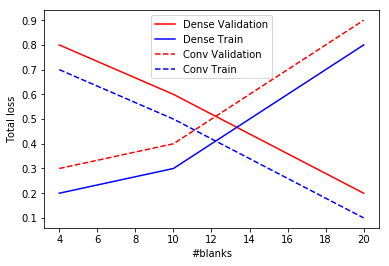

In [16]:
# plot loss # TODO rerun
plt.plot(dense_val_evals[:, 0], dense_val_evals[:, 1], 'r-', label='Dense Validation')
plt.plot(dense_train_evals[:, 0], dense_train_evals[:, 1], 'b-', label='Dense Train')
plt.plot(conv_val_evals[:, 0], conv_val_evals[:, 1], 'r--', label='Conv Validation')
plt.plot(conv_train_evals[:, 0], conv_train_evals[:, 1], 'b--', label='Conv Train')
plt.xlabel('#blanks')
plt.ylabel('Total loss')
plt.legend(loc='best')
plt.show()

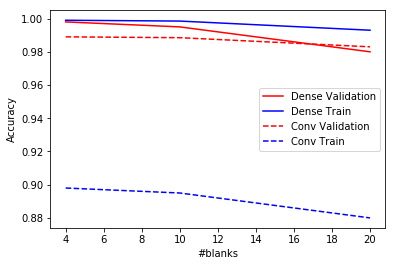

In [17]:
# plot loss # TODO rerun
plt.plot(dense_val_evals[:, 0], dense_val_evals[:, 2], 'r-', label='Dense Validation')
plt.plot(dense_train_evals[:, 0], dense_train_evals[:, 2], 'b-', label='Dense Train')
plt.plot(conv_val_evals[:, 0], conv_val_evals[:, 2], 'r--', label='Conv Validation')
plt.plot(conv_train_evals[:, 0], conv_train_evals[:, 2], 'b--', label='Conv Train')
plt.xlabel('#blanks')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [ ]:
# Evaluate on test set # TODO select the best to run on test set
start = time.time()
test_performance = evaluate_model(conv, X_kaggle_test)
print("Runtime: {} seconds".format(time.time() - start))
print("Number of test puzzles:", X_kaggle_test.shape[0])
print("Number of correctly predicted puzzles:", np.sum(test_performance['validations']))
print("Accuracy:", test_performance['accuracy'])

### Additional evaluation

##### 17-givens.txt dataset with only 17 clues each puzzle

In [54]:
# load 17-givens dataset
given17 = pd.read_csv('./datasets/17-givens.csv').values
print("Full shape:", given17.shape)

Full shape: (49151, 1)


In [25]:
given17

array([['000000010400000000020000000000050407008000300001090000300400200050100000000806000'],
       ['000000010400000000020000000000050604008000300001090000300400200050100000000807000'],
       ['000000012000035000000600070700000300000400800100000000000120000080000040050000600'],
       ...,
       ['140805000006000070000000300000200010300070000500000000800000002010400000000000500'],
       ['080020000030000600000001000000630080100000500200000000000500401002300000700000000'],
       ['060000300400700000000000080000008012500600000000000050082000700000500600000010000']],
      dtype=object)

In [55]:
# preprocess
given17 = preprocess(given17[:, 0])[0]

Initial shape of X: (49151,)
Convert strings in X to: (49151, 81)
Reshape X to: (49151, 9, 9)
Shape of one-hot X: (49151, 9, 9, 10)


In [56]:
# run evaluate
# TODO select the best to run on test set
start = time.time()
given17_performance = evaluate_model(conv, given17)
print("Runtime: {} seconds".format(time.time() - start))
print("Number of test puzzles:", given17.shape[0])
print("Number of correctly predicted puzzles:", np.sum(given17_performance['validations']))
print("Accuracy:", given17_performance['accuracy'])

Number of test puzzles: 49151
Number of correctly predicted puzzles: 0
Accuracy: 0.0


##### UNL Sudoku dataset

In [94]:
# load UNL sudoku dataset
with open('./datasets/sudokus-unl.json') as read_file:
    sudokus_unl = np.array(json.load(read_file))
    
sudokus_unl.shape

(472, 13)

In [31]:
sudokus_unl[0]

array(['99', 'Base', 'Omaha World-Herald', '1', '2', '5',
       'March 24, 2009', '', 'Puzzle added by Jason Gaare',
       '100000026200709010030060000000800700710526038003007000000010050050603007960000004',
       '1', 'GAC', '29'], dtype='<U81')

In [95]:
# preprocess
sudoku_unl_puzzles = preprocess(sudokus_unl[:, 9])[0]

Initial shape of X: (472,)
Convert strings in X to: (472, 81)
Reshape X to: (472, 9, 9)
Shape of one-hot X: (472, 9, 9, 10)


In [96]:
conv = keras.models.load_model('./old_models/conv_model-50.h5')

In [99]:
# run evaluate
# TODO select the best to run on test set
start = time.time()
sudoku_unl_performance = evaluate_model(conv, sudoku_unl_puzzles)
print("Runtime: {} seconds".format(time.time() - start))
print("Number of test puzzles:", sudoku_unl_puzzles.shape[0])
print("Number of correctly predicted puzzles:", np.sum(sudoku_unl_performance['validations']))
print("Accuracy:", sudoku_unl_performance['accuracy'])

Runtime: 6.888916254043579 seconds
Number of test puzzles: 472
Number of correctly predicted puzzles: 19
Accuracy: 0.04025423728813559


In [100]:
# append to original array
sudoku_unl_combined = np.concatenate((sudokus_unl, 
                                      np.expand_dims(sudoku_unl_performance['validations'], 
                                                     axis=1)), 
                                     axis=1)
sudoku_unl_combined

array([['99', 'Base', 'Omaha World-Herald', ..., 'GAC', '29', 'False'],
       ['98', 'Base', 'Daily Nebraskan', ..., 'AC', '29', 'True'],
       ['100', 'Base', 'LA Times', ..., 'SAC', '28', 'False'],
       ...,
       ['637', 'Base', 'Lincoln Journal Star', ..., 'SAC', '25', 'False'],
       ['638', 'Base', 'Evan', ..., 'GAC', '22', 'False'],
       ['639', 'Base', 'RWallace', ..., 'GAC', '28', 'False']],
      dtype='<U81')

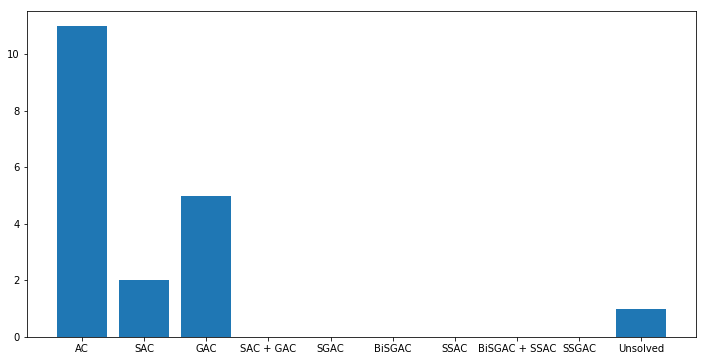

In [114]:
# get solvable instances
solvables = sudoku_unl_combined[sudoku_unl_combined[:, -1] == 'True']

# Examine algorithms
solvable_algos = solvables[:, -3]
counter = Counter(solvable_algos)
algo_count = np.array(list(zip(counter.keys(), counter.values())))
algo_order = {'AC': 0, 'SAC': 1, 'GAC': 2, 'SAC + GAC': 3, 'SGAC': 4,
              'BiSGAC': 5, 'SSAC': 6, 'BiSGAC + SSAC': 7, 'SSGAC': 8,
              'Unsolved': 9}
for algo in algo_order.keys():
    if algo not in algo_count[:, 0]:
        algo_count = np.array(list(algo_count) + [[algo, '0']])
algo_count = np.array(sorted(algo_count, key=lambda x: algo_order[x[0]]))
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(algo_count)), list(map(int, algo_count[:, 1])))
plt.xticks(np.arange(len(algo_count)), algo_count[:, 0])
plt.show()